In [7]:
import optimization, oracles
import numpy as np
import scipy
import experiments
import sklearn
import matplotlib.pyplot as plt
import plot_trajectory_2d as plot
import importlib as imp
import inspect
from pprint import pp
from tqdm import tqdm

# Experiment_0
Проверка градиента и гессиана log_reg_oracle с помощью конечных разностей.

Для линейно разделимой задачи бинарной классификации результаты:

grad l2 LR_norm: 1.34105677986286e-07
hess l2 LR_norm: 13.517675542484723

In [8]:
def log_reg_oracle_checker():
    from sklearn.datasets import make_blobs
    A, b = make_blobs(n_samples=100, centers=2, n_features=3, cluster_std=0.5, random_state=42)

    oracle = oracles.create_log_reg_oracle(A, b, 0.5, oracle_type='usual')
    x = np.ones(A.shape[1])

    grad = oracle.grad(x)

    # тип данных float64 => берем
    eps = 10 ** -np.sqrt(64)
    finite_difference_grad = oracles.grad_finite_diff(oracle.func, x, eps=eps)
    print('grad LR_norm:', np.linalg.norm(finite_difference_grad - grad))
    scipy_grad_LR_norm = scipy.optimize.check_grad(oracle.func, oracle.grad, x)
    print('scipy grad LR_norm:', scipy_grad_LR_norm)

    hess = oracle.hess(x)
    finite_difference_hess = oracles.hess_finite_diff(oracle.func, x, eps=eps ** 3)
    print('hess LR_norm:', np.linalg.norm(finite_difference_hess - hess))


log_reg_oracle_checker()

grad LR_norm: 1.3410567772526975e-07
scipy grad LR_norm: 1.6009397726276042e-07
hess LR_norm: 14.037738530349962


# Experiment_1
Траектория градиентного спуска на квадратичной функции

with func: return 0.5 * np.dot(self.A.dot(x), x) - self.b.dot(x)
with optimization method: gradient_descent
with method: Armijo
with mu: 20
with starting point: [5.22680976 4.3710201 ]
iterations until convergence: 34


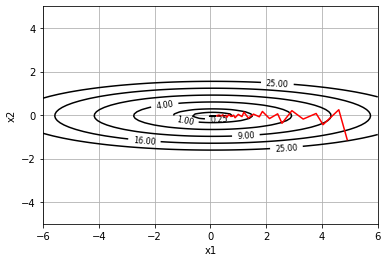

with func: oracle2.func = lambda x: 1 / 2 * np.linalg.norm(A @ x - b) ** 2
with optimization method: gradient_descent
with method: Armijo
with mu: 20
with starting point: [5.22680976 4.3710201 ]
iterations until convergence: 36


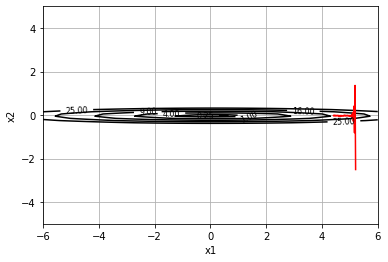

In [9]:
def experiment1_1():
    imp.reload(experiments)
    exp = experiments.Experiment()
    matrix_creation = {"sparse": True, "hard_mode": False}  # one of two

    mus = [i for i in range(5, 100, 5)]
    methods = ["Armijo", "Wolfe", "Constant"]
    starts = [np.random.randn(2) + np.array([i, i]) for i in range(5, 100, 5)]

    mu, n = mus[3], 2
    oracle1, oracle2 = exp.getOracles(mu, n, matrix_creation=matrix_creation)

    exp.experiment(oracle1, mu, methods[0], starts[0], "gradient_descent", plotting=True)
    exp.experiment(oracle2, mu, methods[0], starts[0], "gradient_descent", plotting=True)


if __name__ == "__main__":
    experiment1_1()

# Число обусловленности
В зависимости от числа обусловленности количество итераций градиентного спуска растет линейно.

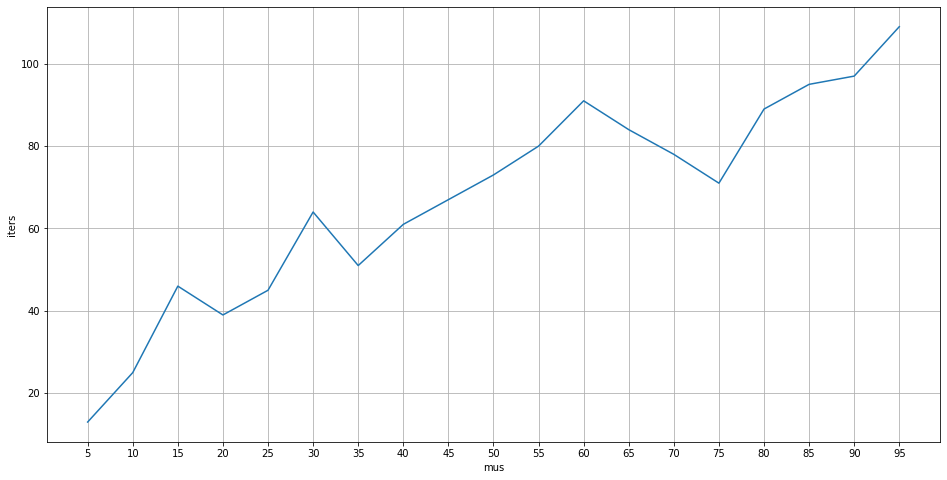

In [10]:
def experiment1_2():
    imp.reload(experiments)
    exp = experiments.Experiment()

    mus = [i for i in range(5, 100, 5)]
    methods = ["Armijo", "Wolfe", "Constant"]
    starts = [np.random.randn(2) + np.array([i, i]) for i in range(5, 100, 5)]
    matrix_creation = {"sparse": False, "hard_mode": False}  # one of two

    iters = exp.calculate_epoch_mu(mus, methods[0], np.random.uniform(0, 500, size=(2)), n=2,
                                   optimization_method="gradient_descent", matrix_creation=matrix_creation)

    return exp, iters, mus


if __name__ == "__main__":
    exp, iters, mus = experiment1_2()
    exp.plot_param(iters, "mus", mus)


# Начальная точка
Количество итераций слабо зависит от начальной точки, большее влияние оказывает число обусловленности

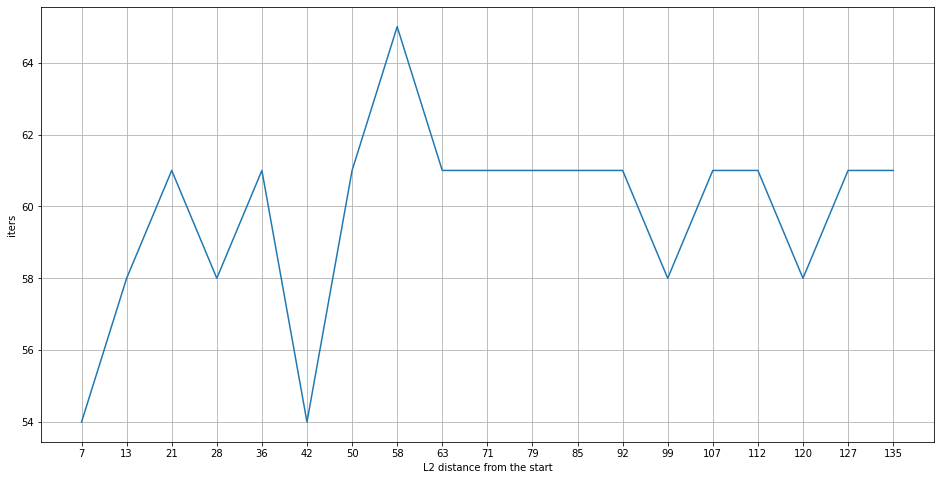

In [32]:
def experiment1_3():
    imp.reload(experiments)
    exp = experiments.Experiment()
    matrix_creation = {"sparse": False, "hard_mode": False}  # one of two

    mus = [i for i in range(5, 100, 5)]
    methods = ["Armijo", "Wolfe", "Constant"]
    starts = [np.random.randn(2) + np.array([i, i]) for i in range(5, 100, 5)]
    iters = exp.calculate_epoch_start(mus[10], methods[0], starts, optimization_method="gradient_descent",
                                      matrix_creation=matrix_creation)
    return exp, iters, starts


if __name__ == "__main__":
    exp, iters, starts = experiment1_3()
    starts = np.asarray(starts)
    exp.plot_param(iters, "L2 distance from the start",
                   np.apply_along_axis(lambda x: round(np.linalg.LR_norm(x)), arr=starts, axis=1).tolist())

# Стратегия выбора шага
**Если график стремится к 0, значит, метод не сошелся за 10_000 итераций**

Если усреднить количество итераций для каждого метода в зависимости от числа обусловленности, то Armijo и Wolfe дают +- одинаковые результаты. Возможно, стоит поиграться с параметрами, чтобы понять, какой метод лучше подходит для разных тип задач.

Константой очень сложной сойтись в принципе, возможно, можно было бы придумать шаг, зависящий от номера итерации по типу $1/n$, тогда могли бы быть другие результаты.

100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


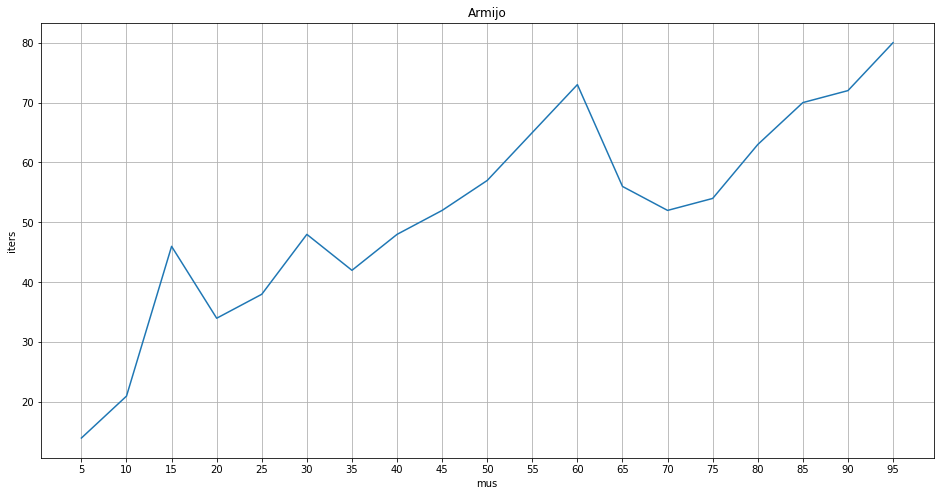

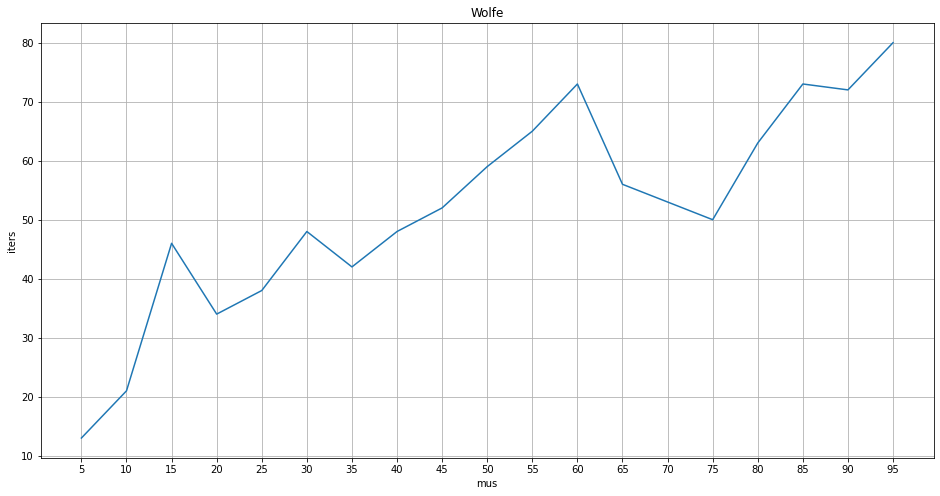

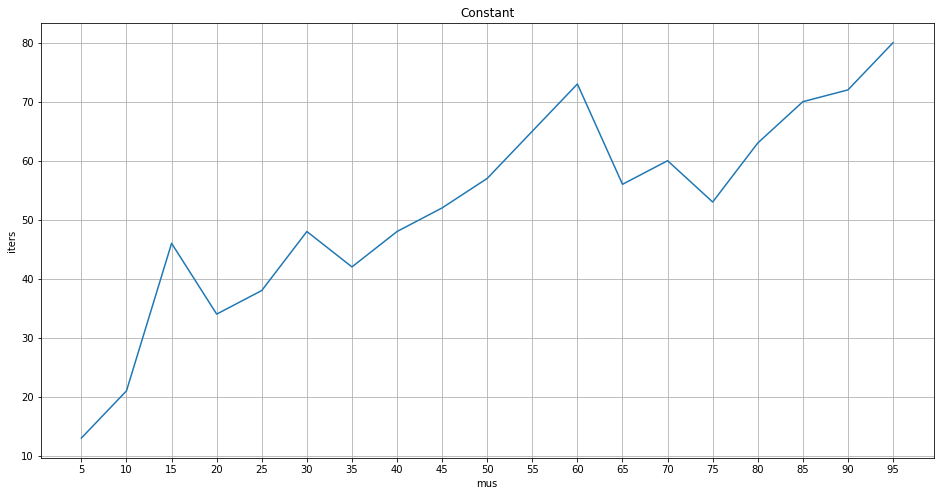

In [40]:
def experiment1_4():
    imp.reload(experiments)
    exp = experiments.Experiment()
    matrix_creation = {"sparse": False, "hard_mode": False}  # one of two

    mus = [i for i in range(5, 100, 5)]
    methods = ["Armijo", "Wolfe", "Constant"]
    starts = [np.random.randn(2) + np.array([i, i]) for i in range(5, 100, 5)]
    d = exp.calculate_epoch_method(methods, mus, starts[3], optimization_method="gradient_descent",
                                   matrix_creation=matrix_creation)
    return exp, d, methods, mus


if __name__ == "__main__":
    exp, d, methods, mus = experiment1_4()
    for k, v in d.items():
        exp.plot_param(v, "mus", mus, method=k)

# Experiment_2
Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров:
1) числа обусловленности κ ≥ 1 оптимизируемой функции
2) размерности пространства n оптимизируемых переменных.

In [7]:
# Исследуйте, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих
# двух параметров: 1) числа обусловленности κ ≥ 1 оптимизируемой функции и
# 2) размерности пространства n оптимизируемых переменных.

# scipy.sparse.diags

100%|██████████| 4/4 [00:29<00:00,  7.47s/it]


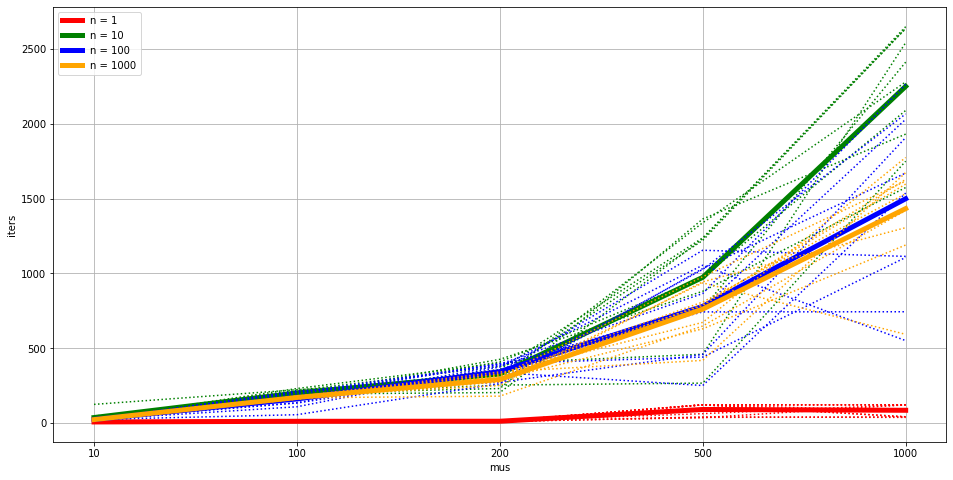

In [8]:
def experiment2_1():
    imp.reload(experiments)
    exp = experiments.Experiment()

    method = "Armijo"

    mus = [10, 100, 200, 500, 1000]
    ns = [10 ** i for i in range(4)]

    d = dict(zip(ns, [[]] * len(ns)))

    matrix_creation = {"sparse": True, "hard_mode": False}  # one of two

    for n in tqdm(ns):
        diff_iters = []
        for _ in tqdm(range(10)):
            start = np.zeros(n)
            iters = exp.calculate_epoch_mu(mus, method, start, n=n, optimization_method="gradient_descent",
                                           matrix_creation=matrix_creation)

            diff_iters.append(iters)

        diff_iters.append(np.asarray(diff_iters).mean(axis=0))
        d[n] = diff_iters

    return exp, d, mus, ns


if __name__ == "__main__":
    cmap = ['red', 'green', 'blue', 'orange', 'black']
    exp, d, mus, ns = experiment2_1()
    exp.plot_param_2(d, mus, ns, cmap)

# Experiment_3

iteration: 0
time: 0.05736279487609863
grad_norm: 0.03320388662128027


iteration: 1
time: 0.12122702598571777
grad_norm: 0.03312694933588618


iteration: 2
time: 0.18488597869873047
grad_norm: 0.0329736209939583


iteration: 3
time: 0.24466681480407715
grad_norm: 0.032669171236187955


iteration: 4
time: 0.3040189743041992
grad_norm: 0.03206926347173368


iteration: 5
time: 0.36388564109802246
grad_norm: 0.030906536388901337


iteration: 6
time: 0.4224967956542969
grad_norm: 0.028735470288141544


iteration: 7
time: 0.4821178913116455
grad_norm: 0.02501874486326019


iteration: 8
time: 0.542834997177124
grad_norm: 0.019759235374468272


iteration: 9
time: 0.6042239665985107
grad_norm: 0.014277228819264768


iteration: 10
time: 0.6667718887329102
grad_norm: 0.00954270285391898


iteration: 11
time: 0.7296457290649414
grad_norm: 0.005819422856453688


iteration: 12
time: 0.792151689529419
grad_norm: 0.003353106902265199


iteration: 13
time: 0.8569457530975342
grad_norm: 0.0018255673396

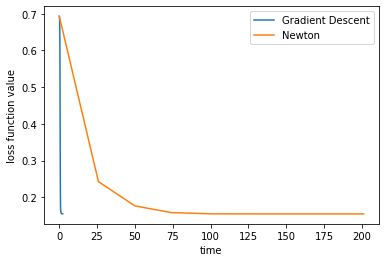

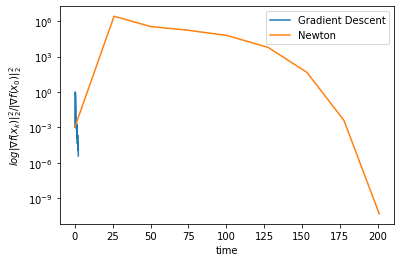

In [19]:
from sklearn.model_selection import train_test_split
import sklearn


def gd_newton_comparison(svm_file):
    A, b = sklearn.datasets.load_svmlight_file(svm_file)
    A, _, b, _ = train_test_split(A, b, test_size=0.2)
    regularization = 1.0 / b.size
    oracle = oracles.create_log_reg_oracle(A, b, regularization)
    _, _, history_gd = optimization.gradient_descent(oracle,
                                                     np.zeros(A.shape[1]),
                                                     trace=True,
                                                     display=True)

    plt.xlabel('time')
    plt.ylabel('loss function value')

    plt.plot(history_gd['time'],
             history_gd['func'],
             label="Gradient Descent")

    _, _, history_n = optimization.newton(oracle,
                                          np.zeros(A.shape[1]),
                                          display=True,
                                          trace=True)

    plt.plot(history_n['time'],
             history_n['func'],
             label="Newton")

    plt.legend()
    plt.savefig('func.png')
    plt.show()

    grad = oracle.grad(np.zeros(A.shape[1]))
    grad_0_LR_norm = 1.0 / grad.dot(grad)

    plt.plot(history_gd['time'],
             np.square(np.array(history_gd['grad_LR_norm'])) * grad_0_LR_norm,
             label="Gradient Descent")
    plt.plot(history_n['time'],
             np.square(np.array(history_n['grad_LR_norm'])) * grad_0_LR_norm,
             label="Newton")

    plt.yscale('log')
    plt.xlabel('time')
    plt.ylabel(r'$log  \| \nabla f(x_k) \|_2^2 / \| \nabla f(x_0) \|_2^2$')
    plt.legend()
    plt.savefig('grad.png')
    plt.show()


gd_newton_comparison('sources/w8a')
# gd_newton_comparison('sources/gisette_scale.bz2')
# gd_newton_comparison('sources/real-sim.bz2')


# Experiment_4

In [217]:
grid = [{'method': 'Constant', 'c': 1},
        {'method': 'Constant', 'c': 1e-2},
        {'method': 'Constant', 'c': 1e-3},
        {'method': 'Armijo', 'c1': 1e-2},
        {'method': 'Armijo', 'c1': 1e-3},
        {'method': 'Armijo', 'c1': 1e-4},
        {'method': 'Wolfe', 'c2': 0.9},
        {'method': 'Wolfe', 'c2': 0.5},
        {'method': 'Wolfe', 'c2': 0.2}, ]

A = np.random.randn(2, 2)
A = (A + A.T) / 2

for i in range(2):
    A[i][i] = 16 ** i

b = np.sign(np.random.randn(2))

oracle_quad = oracles.QuadraticOracle(A, b)
A = np.random.rand(5_000, 100)
y = np.sign(np.random.rand(5000))

oracle_lr = oracles.create_log_reg_oracle(A, y, regcoef=1 / 100)

QR_func, LR_norm, QR_iters, LR_iters = [], [], [], []

for i, ls in enumerate(grid):
    _, _, QR_hist = optimization.gradient_descent(oracle_quad, x_0=[10, 20], line_search_options=ls, trace=True)
    _, _, LR_hist = optimization.gradient_descent(oracle_lr, x_0=np.random.randint(5, 10, size=100),
                                                  line_search_options=ls,
                                                  trace=True)

    QR_func.append(QR_hist['func'])
    LR_norm.append(LR_hist['grad_norm'])
    QR_iters.append(len(QR_hist['x']))
    LR_iters.append(len(LR_hist['grad_norm']))

/Users/dev.daniil.bakushkin/Desktop/Опты/Labs/lab1/dev/oracles.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return 0.5 * np.dot(self.A.dot(x), x) - self.b.dot(x)
/Users/dev.daniil.bakushkin/Desktop/Опты/Labs/lab1/dev/optimization.py:208: RuntimeWarning: invalid value encountered in subtract
  x_k = x_k - a_k * d_k


In [232]:
colors = ['green', 'orange', 'purple', 'black', 'red', 'blue', 'indigo', 'aqua', 'slateblue']
names = ['Constant c=1',
         'Constant c=0.01',
         'Constant c=0.001',
         'Armijo c1=0.01',
         'Armijo c1=0.001',
         'Armijo c1=0.0001',
         'Wolfe c2=0.9',
         'Wolfe c2=0.5',
         'Wolfe c2=0.2']

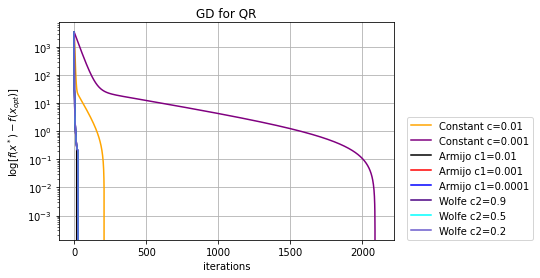

In [233]:
for i in range(1, len(QR_func)):
    plt.plot(np.arange(QR_iters[i]), np.array(QR_func[i][:-1]), label=names[i], c=colors[i])

plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel(r'$\log[f(x^*) - f(x_{opt})]$')
plt.title('GD for QR')
plt.grid()
plt.legend(loc=(1.04, 0))

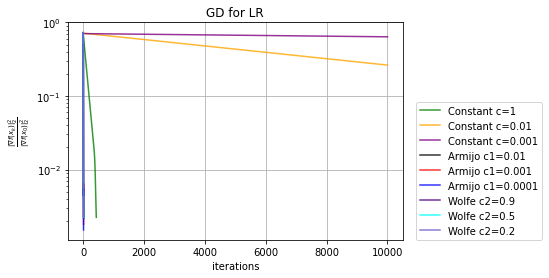

In [230]:
for i in range(len(QR_func)):
    plt.plot(np.arange(LR_iters[i]), np.array(LR_norm[i]), label=names[i], c=colors[i], alpha=0.8)

plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel(r'$\frac{\left\|\nabla f\left(x_k\right)\right\|_2^2}{\left\|\nabla f\left(x_0\right)\right\|_2^2}$')
plt.title('GD for LR')
plt.grid()
plt.legend(loc=(1.04, 0))

# Newton

In [234]:
grid = [{'method': 'Constant', 'c': 1},
        {'method': 'Constant', 'c': 1e-2},
        {'method': 'Constant', 'c': 1e-3},
        {'method': 'Armijo', 'c1': 1e-2},
        {'method': 'Armijo', 'c1': 1e-3},
        {'method': 'Armijo', 'c1': 1e-4},
        {'method': 'Wolfe', 'c2': 0.9},
        {'method': 'Wolfe', 'c2': 0.5},
        {'method': 'Wolfe', 'c2': 0.2}, ]

A = np.random.randn(2, 2)
A = (A + A.T) / 2

for i in range(2):
    A[i][i] = 16 ** i

b = np.sign(np.random.randn(2))

oracle_quad = oracles.QuadraticOracle(A, b)
A = np.random.rand(5_000, 100)
y = np.sign(np.random.rand(5000))

oracle_lr = oracles.create_log_reg_oracle(A, y, regcoef=1 / 100)

QR_func, LR_norm, QR_iters, LR_iters = [], [], [], []

for i, ls in tqdm(enumerate(grid)):
    _, _, QR_hist = optimization.newton(oracle_quad, x_0=[10, 20], line_search_options=ls, trace=True)
    _, _, LR_hist = optimization.newton(oracle_lr, x_0=np.random.randint(5, 10, size=100),
                                                  line_search_options=ls,
                                                  trace=True)

    QR_func.append(QR_hist['func'])
    LR_norm.append(LR_hist['grad_norm'])
    QR_iters.append(len(QR_hist['x']))
    LR_iters.append(len(LR_hist['grad_norm']))

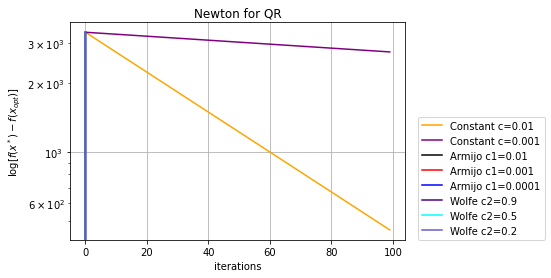

In [237]:
for i in range(1, len(QR_func)):
    plt.plot(np.arange(QR_iters[i]), np.array(QR_func[i][:-1]), label=names[i], c=colors[i])

plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel(r'$\log[f(x^*) - f(x_{opt})]$')
plt.title('Newton for QR')
plt.grid()
plt.legend(loc=(1.04, 0))

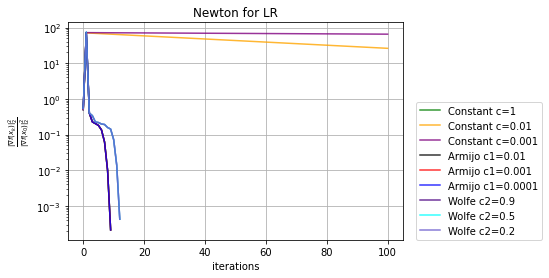

In [238]:
for i in range(len(QR_func)):
    plt.plot(np.arange(LR_iters[i]), np.array(LR_norm[i]), label=names[i], c=colors[i], alpha=0.8)

plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel(r'$\frac{\left\|\nabla f\left(x_k\right)\right\|_2^2}{\left\|\nabla f\left(x_0\right)\right\|_2^2}$')
plt.title('Newton for LR')
plt.grid()
plt.legend(loc=(1.04, 0))